- let's get into the Scikit-learn implementation examples for DBSCAN.
- We'll do two examples to showcase its ability to find arbitrarily shaped clusters and identify noise.
- **Important Note:** DBSCAN is highly sensitive to feature scales because it relies on a distance measure (eps). Feature scaling (e.g., using StandardScaler) is almost always a necessary preprocessing step.

#### Example 1: DBSCAN on make_moons Dataset

- This dataset is ideal for demonstrating DBSCAN's ability to find non-globular (non-spherical) clusters, which K-Means would struggle with.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score # For evaluating clustering quality
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# --- 1. Generate Synthetic Non-Linear Data (make_moons) ---
n_samples = 300
X_moons, y_moons_true = make_moons(n_samples=n_samples, noise=0.07, random_state=42)

X_moons_df = pd.DataFrame(X_moons, columns=['Feature_1', 'Feature_2'])
print("Synthetic 'make_moons' Dataset Generated for DBSCAN.")
print(f"Features shape: {X_moons_df.shape}")


Synthetic 'make_moons' Dataset Generated for DBSCAN.
Features shape: (300, 2)


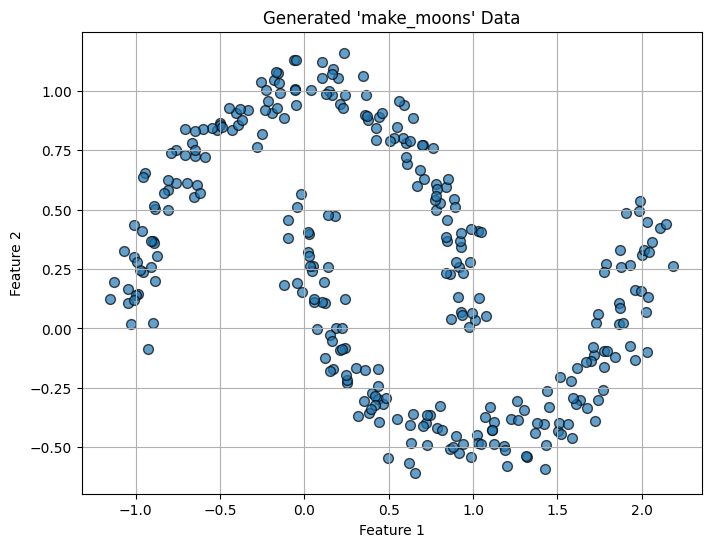

In [3]:
# Visualize the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X_moons_df['Feature_1'], X_moons_df['Feature_2'], s=50, alpha=0.7, edgecolors='k')
plt.title("Generated 'make_moons' Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [4]:
# --- 2. Feature Scaling ---
scaler_moons = StandardScaler()
X_moons_scaled = scaler_moons.fit_transform(X_moons_df)
print("\nData Scaled.")


Data Scaled.


In [5]:
# --- 3. Determine Parameters (eps and min_samples) ---
# For 'eps', we can use the k-distance plot method.
# Let's choose min_samples. For 2D data, min_samples around 3-5 is common.
# Let's try min_samples = 5. So, we look at the distance to the 4th nearest neighbor (k=min_samples-1).
from sklearn.neighbors import NearestNeighbors

min_samples_chosen = 5
k_neighbor = min_samples_chosen -1 # or min_samples_chosen for some conventions


In [6]:
# Calculate distances to k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=min_samples_chosen).fit(X_moons_scaled) # Fit on all scaled data
distances, indices = nbrs.kneighbors(X_moons_scaled)


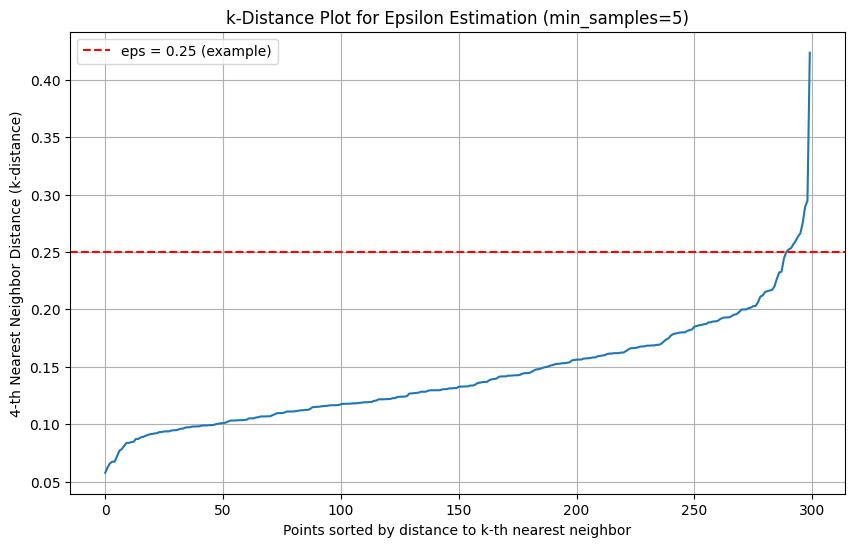

In [7]:
# Distances to the k-th neighbor (min_samples-th neighbor if k_neighbor=min_samples_chosen)
# We are interested in the distance to the k_neighbor-th point in the sorted list of distances for each point
# The last column of distances array (distances[:,k_neighbor]) contains these
k_distances = np.sort(distances[:, k_neighbor], axis=0) # Sort the k-th distances

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{k_neighbor}-th Nearest Neighbor Distance (k-distance)")
plt.title(f"k-Distance Plot for Epsilon Estimation (min_samples={min_samples_chosen})")
plt.grid(True)
# Look for an "elbow" or a point of sharp increase.
# For this data, an eps around 0.2 to 0.3 might be reasonable from the plot.
# Let's try eps = 0.25 or 0.3
plt.axhline(y=0.25, color='r', linestyle='--', label='eps = 0.25 (example)')
plt.legend()
plt.show()

In [8]:
eps_chosen = 0.3 # Chosen based on visual inspection of k-distance plot
print(f"\nChosen parameters: eps = {eps_chosen}, min_samples = {min_samples_chosen}")



Chosen parameters: eps = 0.3, min_samples = 5


In [9]:
# --- 4. Apply DBSCAN ---
print(f"\n--- Applying DBSCAN with eps={eps_chosen} and min_samples={min_samples_chosen} ---")
dbscan_moons = DBSCAN(eps=eps_chosen, min_samples=min_samples_chosen, metric='euclidean')
cluster_labels_moons = dbscan_moons.fit_predict(X_moons_scaled)



--- Applying DBSCAN with eps=0.3 and min_samples=5 ---


In [10]:
# Cluster labels: -1 indicates noise points. Other non-negative integers are cluster IDs.
n_clusters_found = len(set(cluster_labels_moons)) - (1 if -1 in cluster_labels_moons else 0)
n_noise_points = np.sum(cluster_labels_moons == -1)

print(f"Estimated number of clusters: {n_clusters_found}")
print(f"Number of noise points: {n_noise_points} out of {len(X_moons_scaled)} points")


Estimated number of clusters: 2
Number of noise points: 0 out of 300 points


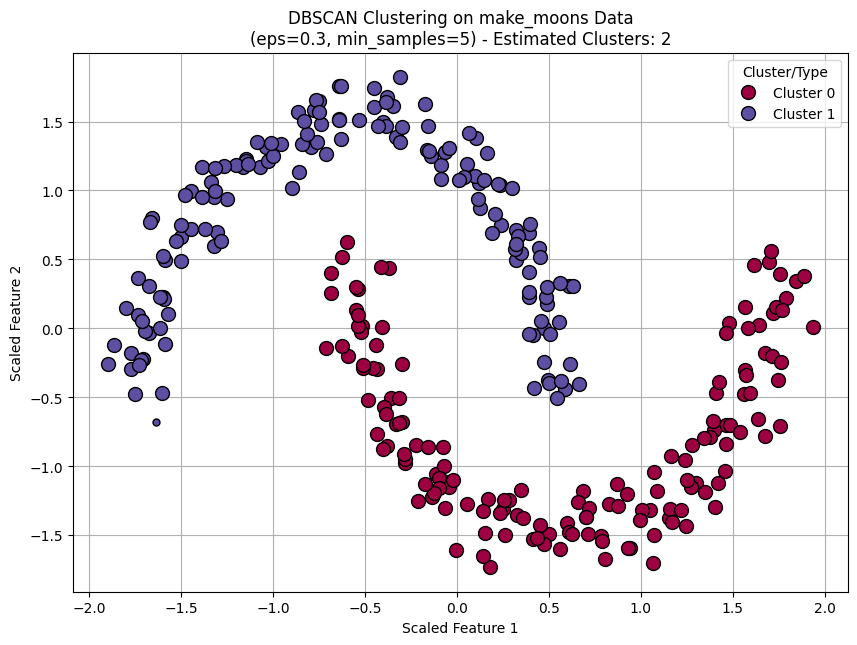


Silhouette Score: 0.3824


In [13]:
# --- 5. Visualize the Clustering Results ---
plt.figure(figsize=(10, 7))

# Plot core samples, border samples, and noise
# Create a mask for core samples
core_samples_mask = np.zeros_like(cluster_labels_moons, dtype=bool)
core_samples_mask[dbscan_moons.core_sample_indices_] = True

unique_labels = set(cluster_labels_moons)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1: # Noise points
        col = [0, 0, 0, 1] # Black for noise

    class_member_mask = (cluster_labels_moons == k)

    # Plot core samples
    xy_core = X_moons_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy_core[:, 0], xy_core[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label=f'Cluster {k}' if k !=-1 else 'Noise')

    # Plot non-core samples (border points)
    xy_border = X_moons_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy_border[:, 0], xy_border[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5, label=f'Border {k}' if k !=-1 and len(xy_core)==0 else None)

plt.title(f"DBSCAN Clustering on make_moons Data\n(eps={eps_chosen}, min_samples={min_samples_chosen}) - Estimated Clusters: {n_clusters_found}")
plt.xlabel("Scaled Feature 1")
plt.ylabel("Scaled Feature 2")
# Create a legend that doesn't duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Cluster/Type")
plt.grid(True)
plt.show()

# Evaluate clustering if there are at least 2 clusters found (excluding noise)
if n_clusters_found > 1:
    silhouette_avg_moons = silhouette_score(X_moons_scaled, cluster_labels_moons)
    print(f"\nSilhouette Score: {silhouette_avg_moons:.4f}")
else:
    print("\nSilhouette Score cannot be calculated with < 2 clusters (excluding noise).")



**Discussion for make_moons DBSCAN Example:**

- k-distance Plot: This plot is a common heuristic to help choose eps. You look for the "elbow" point where the distance starts to rise sharply. The y-value at this elbow is a good candidate for eps.
- Cluster Discovery: DBSCAN should correctly identify the two moon-shaped clusters and potentially some points as noise if they are too far from the dense regions, depending on the eps and min_samples chosen.
- Noise Points: The points labeled -1 are considered noise by DBSCAN.
- Visualization: The plot distinguishes core samples (larger markers) from border samples (smaller markers) within each cluster, and noise points are typically plotted in black.
- Silhouette Score: This metric can give an idea of how well-separated the clusters are. Scores closer to +1 are better.


---
#### Example 2: DBSCAN on Synthetic make_blobs Data with Varied Densities/Noise

- This example will use make_blobs but we can try to create a scenario where K-Means might struggle more, or where DBSCAN's noise handling is beneficial. Let's generate blobs and add some random noise points.

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

Synthetic 'make_blobs' Dataset with Added Noise Generated for DBSCAN.
Total features shape: (350, 2)


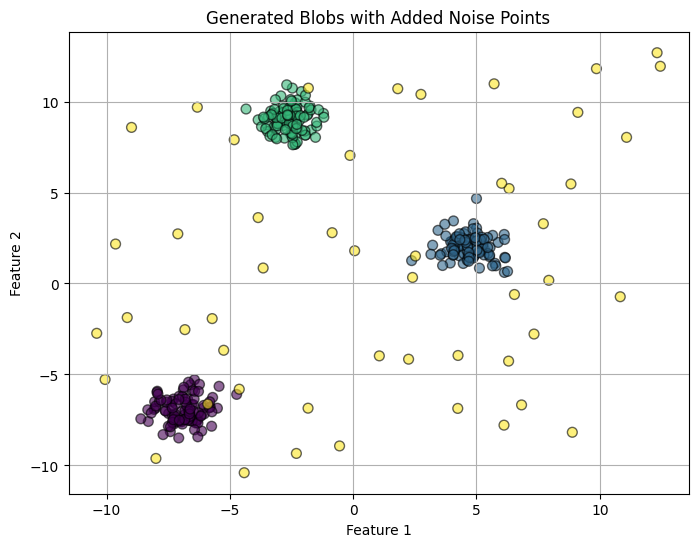

In [15]:
# --- 1. Generate Synthetic Data with Clusters and Add Noise ---
n_samples_main = 300
n_blobs = 3
random_state = 42

X_main_blobs, y_true_blobs = make_blobs(n_samples=n_samples_main,
                                        centers=n_blobs,
                                        cluster_std=0.7,
                                        random_state=random_state)

# Add some random noise points
n_noise_points = 50
# Generate noise points in a wider range than the blobs
min_val = X_main_blobs.min() - 2
max_val = X_main_blobs.max() + 2
X_noise = np.random.uniform(low=min_val, high=max_val, size=(n_noise_points, X_main_blobs.shape[1]))

X_blobs_noisy = np.vstack((X_main_blobs, X_noise))
# Create true labels: original blob labels, and -1 for added noise (for evaluation only)
y_true_noisy = np.concatenate((y_true_blobs, np.full(n_noise_points, -1)))


X_blobs_noisy_df = pd.DataFrame(X_blobs_noisy, columns=['Feature_1', 'Feature_2'])
print("Synthetic 'make_blobs' Dataset with Added Noise Generated for DBSCAN.")
print(f"Total features shape: {X_blobs_noisy_df.shape}")

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs_noisy_df['Feature_1'], X_blobs_noisy_df['Feature_2'],
            c=y_true_noisy, cmap='viridis_r', s=50, alpha=0.6, edgecolors='k') # Color by true origin for context
plt.title("Generated Blobs with Added Noise Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [16]:
# --- 2. Feature Scaling ---
scaler_blobs_noisy = StandardScaler()
X_blobs_noisy_scaled = scaler_blobs_noisy.fit_transform(X_blobs_noisy_df)
print("\nData Scaled.")


Data Scaled.


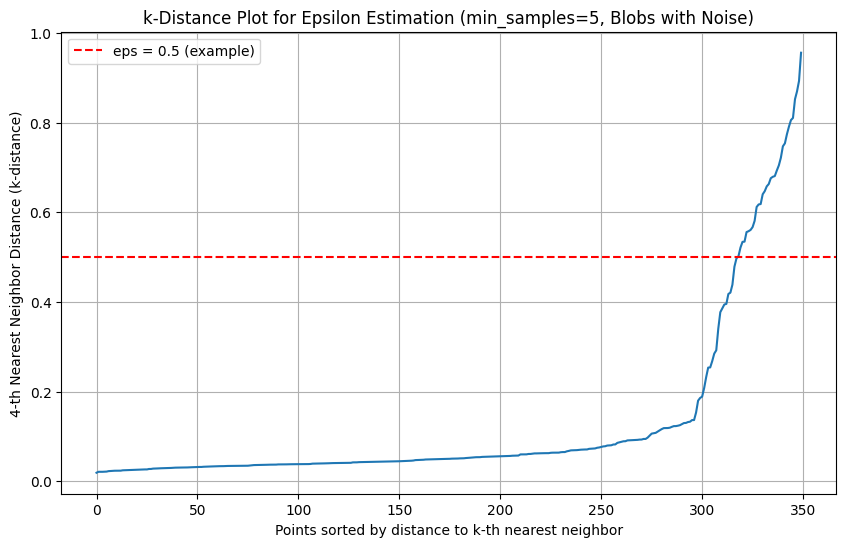


Chosen parameters: eps = 0.5, min_samples = 5


In [17]:
# --- 3. Determine Parameters (eps and min_samples) using k-distance plot ---
min_samples_bn = 5 # A common starting point for 2D
k_neighbor_bn = min_samples_bn - 1

nbrs_bn = NearestNeighbors(n_neighbors=min_samples_bn).fit(X_blobs_noisy_scaled)
distances_bn, indices_bn = nbrs_bn.kneighbors(X_blobs_noisy_scaled)
k_distances_bn = np.sort(distances_bn[:, k_neighbor_bn], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(k_distances_bn)
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{k_neighbor_bn}-th Nearest Neighbor Distance (k-distance)")
plt.title(f"k-Distance Plot for Epsilon Estimation (min_samples={min_samples_bn}, Blobs with Noise)")
plt.grid(True)
# Look for an elbow. For this data, maybe around 0.4-0.6
eps_bn_chosen = 0.5 # Example based on potential elbow
plt.axhline(y=eps_bn_chosen, color='r', linestyle='--', label=f'eps = {eps_bn_chosen} (example)')
plt.legend()
plt.show()
print(f"\nChosen parameters: eps = {eps_bn_chosen}, min_samples = {min_samples_bn}")


In [18]:
# --- 4. Apply DBSCAN ---
print(f"\n--- Applying DBSCAN with eps={eps_bn_chosen} and min_samples={min_samples_bn} (Blobs with Noise) ---")
dbscan_blobs_noisy = DBSCAN(eps=eps_bn_chosen, min_samples=min_samples_bn, metric='euclidean')
cluster_labels_bn = dbscan_blobs_noisy.fit_predict(X_blobs_noisy_scaled)

n_clusters_found_bn = len(set(cluster_labels_bn)) - (1 if -1 in cluster_labels_bn else 0)
n_noise_points_found_bn = np.sum(cluster_labels_bn == -1)

print(f"Estimated number of clusters: {n_clusters_found_bn}")
print(f"Number of noise points found: {n_noise_points_found_bn} (Expected around {n_noise_points} added noise)")


--- Applying DBSCAN with eps=0.5 and min_samples=5 (Blobs with Noise) ---
Estimated number of clusters: 4
Number of noise points found: 20 (Expected around 50 added noise)


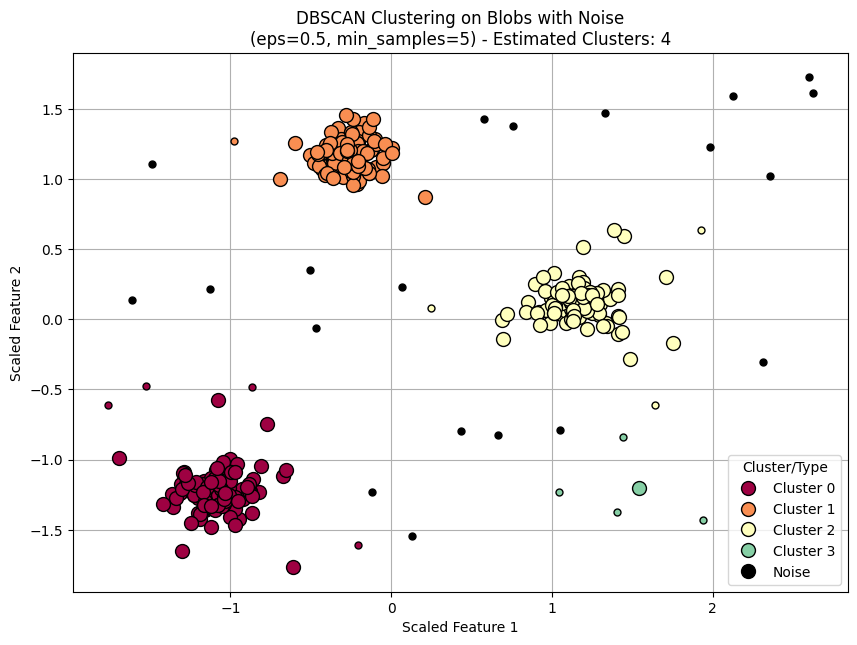


Adjusted Rand Index for original blobs (vs their true labels): 1.0000
Out of 50 added noise points, 20 were correctly identified as noise by DBSCAN.
Silhouette Score (excluding noise points): 0.8397


In [19]:
# --- 5. Visualize the Clustering Results ---
plt.figure(figsize=(10, 7))
core_samples_mask_bn = np.zeros_like(cluster_labels_bn, dtype=bool)
core_samples_mask_bn[dbscan_blobs_noisy.core_sample_indices_] = True
unique_labels_bn = set(cluster_labels_bn)
colors_bn = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_bn))]

for k, col in zip(unique_labels_bn, colors_bn):
    if k == -1: col = [0, 0, 0, 1] # Black for noise
    class_member_mask_bn = (cluster_labels_bn == k)
    xy_core_bn = X_blobs_noisy_scaled[class_member_mask_bn & core_samples_mask_bn]
    plt.plot(xy_core_bn[:, 0], xy_core_bn[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10, label=f'Cluster {k}' if k!=-1 else 'Noise')
    xy_border_bn = X_blobs_noisy_scaled[class_member_mask_bn & ~core_samples_mask_bn]
    plt.plot(xy_border_bn[:, 0], xy_border_bn[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, label=f'Border {k}' if k!=-1 and len(xy_core_bn)==0 else None)

plt.title(f"DBSCAN Clustering on Blobs with Noise\n(eps={eps_bn_chosen}, min_samples={min_samples_bn}) - Estimated Clusters: {n_clusters_found_bn}")
plt.xlabel("Scaled Feature 1")
plt.ylabel("Scaled Feature 2")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Cluster/Type")
plt.grid(True)
plt.show()

# Evaluate (optional, as we have some ground truth for the main blobs and know which are noise)
# We can compare how many of the *added* noise points were correctly identified as noise by DBSCAN.
# And how well the original blobs were clustered.
if n_clusters_found_bn > 0 : # Only if some clusters were found
    # For original blobs (excluding added noise)
    original_blob_mask = (y_true_noisy != -1)
    ari_blobs_main = adjusted_rand_score(y_true_noisy[original_blob_mask], cluster_labels_bn[original_blob_mask])
    print(f"\nAdjusted Rand Index for original blobs (vs their true labels): {ari_blobs_main:.4f}")

    # For noise points
    added_noise_mask = (y_true_noisy == -1)
    correctly_identified_noise = np.sum(cluster_labels_bn[added_noise_mask] == -1)
    print(f"Out of {n_noise_points} added noise points, {correctly_identified_noise} were correctly identified as noise by DBSCAN.")

    if n_clusters_found_bn > 1: # Silhouette score needs at least 2 clusters
        silhouette_avg_bn = silhouette_score(X_blobs_noisy_scaled[cluster_labels_bn != -1], cluster_labels_bn[cluster_labels_bn != -1]) # Exclude noise for silhouette
        print(f"Silhouette Score (excluding noise points): {silhouette_avg_bn:.4f}")
else:
    print("\nNo clusters found or only noise points identified.")



**Discussion for make_blobs with Noise DBSCAN Example:**

- Noise Identification: This example explicitly adds random noise points. DBSCAN should be able to identify many of these as noise (label -1) if eps and min_samples are chosen appropriately.
- Parameter Sensitivity: You might need to experiment with eps and min_samples to get a good separation of the true blobs while correctly flagging the added noise. The k-distance plot is a helpful starting point.
- Evaluation: We can evaluate how well DBSCAN identified the original blobs (using ARI against their true labels) and how many of the intentionally added noise points were correctly labeled as noise by the algorithm.
- The visualization will clearly show the formed clusters and the points classified as noise.
- These two examples should give you a good practical understanding of how DBSCAN works, its ability to handle different cluster shapes, identify noise, and the importance of its hyperparameters.